In [1]:
import ffsim
from ffsim.variational.util import interaction_pairs_spin_balanced
from las_lucj.ucj_frag import ucj_frag_circuit
from qiskit.circuit import QuantumCircuit, QuantumRegister
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

GATE_MAP = {
    ffsim.UCJOpSpinBalanced: ffsim.qiskit.UCJOpSpinBalancedJW,
    ffsim.UCJOpSpinUnbalanced: ffsim.qiskit.UCJOpSpinUnbalancedJW,
}


def ucj_frag_circuit_naive(
    small_ucj_ops: list[ffsim.UCJOpSpinBalanced | ffsim.UCJOpSpinUnbalanced],
    nelecs: list[tuple[int, int]],
    big_ucj_op: ffsim.UCJOpSpinBalanced | ffsim.UCJOpSpinUnbalanced,
) -> QuantumCircuit:
    norb = sum(op.norb for op in small_ucj_ops)
    assert norb == big_ucj_op.norb
    qubits = QuantumRegister(2 * norb, name="q")
    circuit = QuantumCircuit(qubits)
    current_orb = 0
    for op, nelec in zip(small_ucj_ops, nelecs):
        active_qubits = (
            qubits[current_orb : current_orb + op.norb]
            + qubits[norb + current_orb : norb + current_orb + op.norb]
        )
        circuit.append(ffsim.qiskit.PrepareHartreeFockJW(op.norb, nelec), active_qubits)
        circuit.append(GATE_MAP[type(op)](op), active_qubits)
        current_orb += op.norb
    circuit.barrier()
    circuit.append(GATE_MAP[type(big_ucj_op)](big_ucj_op), qubits)
    return circuit


norb = 6
nelec = (3, 3)
n_alpha, n_beta = nelec
norb_small_1 = 3
nelec_small_1 = (1, 2)
n_alpha_small_1, n_beta_small_1 = nelec_small_1
norb_small_2 = 3
nelec_small_2 = (2, 1)
n_alpha_small_2, n_beta_small_2 = nelec_small_2
assert norb_small_1 + norb_small_2 == norb
assert n_alpha_small_1 + n_alpha_small_2 == n_alpha
assert n_beta_small_1 + n_beta_small_2 == n_beta

pairs_aa, pairs_ab = interaction_pairs_spin_balanced("heavy-hex", norb_small_1)
ucj_op_small_1 = ffsim.random.random_ucj_op_spin_unbalanced(
    norb=norb_small_1,
    n_reps=1,
    interaction_pairs=(pairs_aa, pairs_ab, pairs_aa),
)
pairs_aa, pairs_ab = interaction_pairs_spin_balanced("heavy-hex", norb_small_2)
ucj_op_small_2 = ffsim.random.random_ucj_op_spin_unbalanced(
    norb=norb_small_2,
    n_reps=1,
    interaction_pairs=(pairs_aa, pairs_ab, pairs_aa),
)
ucj_op_big = ffsim.random.random_ucj_op_spin_balanced(
    norb=norb,
    n_reps=2,
    interaction_pairs=interaction_pairs_spin_balanced("heavy-hex", norb),
)

circuit_naive = ucj_frag_circuit_naive(
    [ucj_op_small_1, ucj_op_small_2], [nelec_small_1, nelec_small_2], ucj_op_big
)

circuit_opt = ucj_frag_circuit(
    [ucj_op_small_1, ucj_op_small_2], [nelec_small_1, nelec_small_2], ucj_op_big
)

In [2]:
# Create a generic backend and transpile the circuit to it
backend = GenericBackendV2(2 * norb, basis_gates=["cp", "xx_plus_yy", "p", "x"])
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
# Set the pre-initialization stage of the pass manager with passes suggested by ffsim
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
transpiled_naive = pass_manager.run(circuit_naive)
transpiled_opt = pass_manager.run(circuit_opt)

In [3]:
transpiled_naive.count_ops()

OrderedDict([('xx_plus_yy', 110),
             ('p', 48),
             ('cp', 34),
             ('x', 6),
             ('barrier', 1)])

In [4]:
transpiled_opt.count_ops()

OrderedDict([('xx_plus_yy', 98), ('p', 36), ('cp', 34), ('x', 6)])

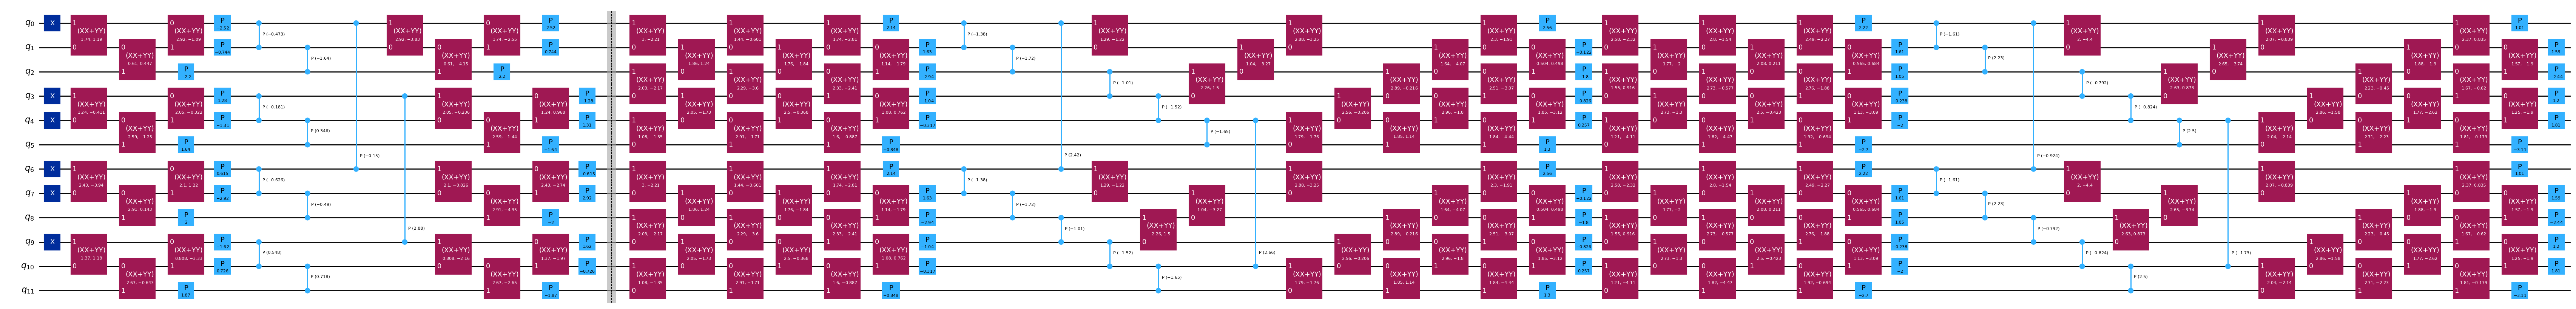

In [5]:
circuit_naive.decompose(reps=2).draw("mpl", fold=-1)

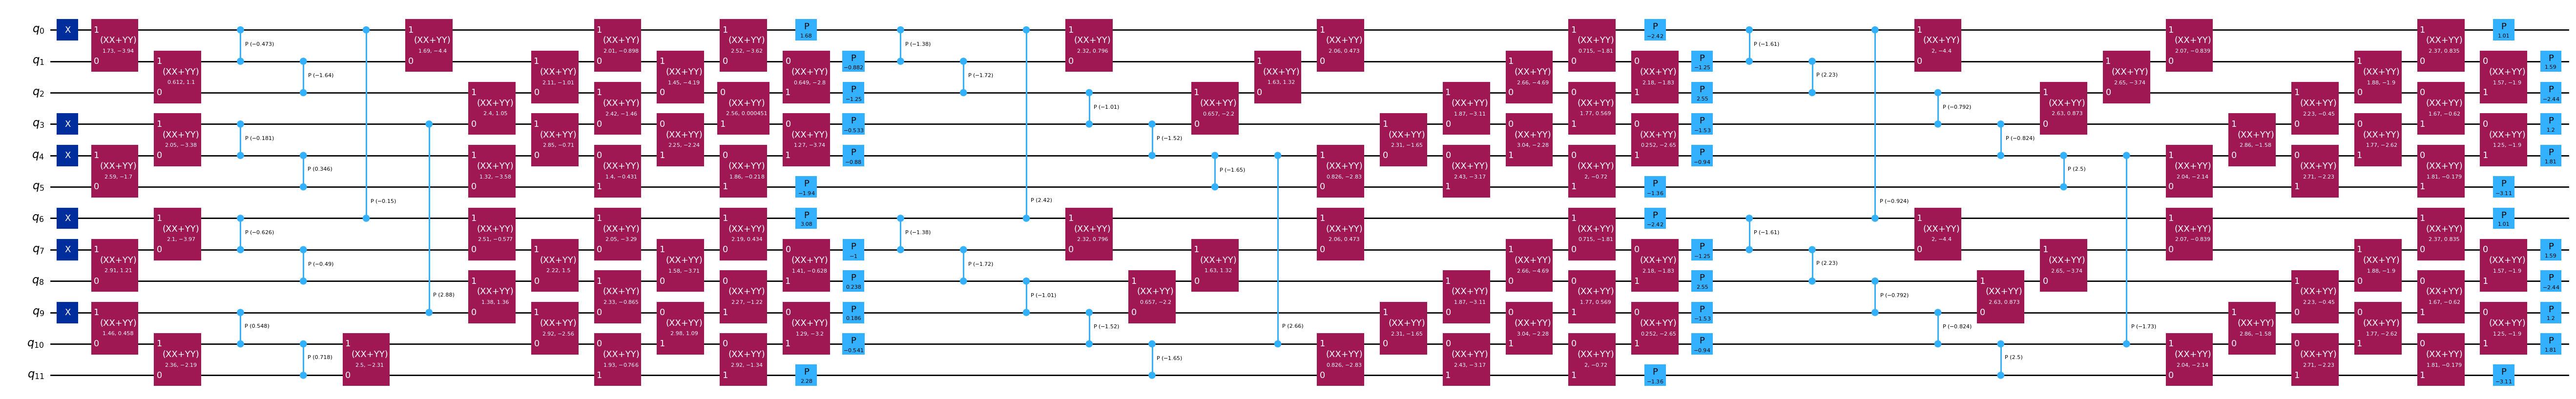

In [6]:
circuit_opt.decompose(reps=1).draw("mpl", fold=-1)